# Final project: URL Phishing Detection

# Project Description
**Presentation**

**Abstract**

Different machine learning algorithms had been used to solve different text classification problems over
the years. This project aims to explore the text classification area by detecting phishing websites using
their URLs. In this project I will build a robust phishing detection mechanism using machine learning tools
and techniques and will compare the different algorithm and their success rates in detecting phishing
websites

**Data sources**

Several sources could be use:

- A source with 10,000 websites with 49 'raw' features (5k phishing and 5k normal) : https://data.mendeley.com/datasets/h3cgnj8hft/1/
- A source with classefied/normilized features (all values are booleans): https://archive.ics.uci.edu/ml/datasets/phishing+websites
- The best phishing DB (only URLs, no features): https://www.phishtank.com/index.php

I used the source with the raw features.

**Models**

The purpose of this project is to compare several known classification algorithms. I will compare the following algorithms:

- Logistic Regression
- Decision Tree
- KNN
- SVM
- Naive Bayes
- Convolutional Neural Networks


**Methods**

Inorder to evaluate the algorithms performance, I will use two methods: simple accuracy and ROC curve.

Several of the features seems to have no real effect on the results, so I will first run the algorithms on the raw data, and then I will try to adujst the features list in order to improve the algorithms run time and accuracy.

**Expectations**

As demonstrated in class, the neural network approach should yield the best results in the classification.
My gut feeling is that there will be a strong linear connection between the features, such as the URL
length, and the class. Therefor I predict that the Logistic Regression model will yield good results, but it
looks like a task better suited for neural networks.


# Results summary

**Models params selection -**

KNN:

Since the data has both catagorial (boolean) and numeric features, KNN algorithm should use a special metric - heterogeneous euclidean-overlap metric (HEOM). I found this python lib - https://pypi.org/project/distython/ - but for the love of god, I couldn't make it work. So, I used the hamming metric since it yielded the best results.

**Results -**

All the algorithms performed well and above my expectations. We can see that indeed the linear models have a slight advantage with the best AUC, though the decision tree has the best accuracy. Regarding the feature selection, the algorithms actually performed poorer but obviusly run much faster. I guess some of the features caused the algorithms to over fit.


Before the features selection -

1. Decision Tree - Accuracy: 0.96 (+/- 0.01), AUC: 0.96
1. SVM Linear SVC - Accuracy: 0.94 (+/- 0.03), AUC: 0.98
1. Logistic Regression - Accuracy: 0.93 (+/- 0.03), AUC: 0.98
1. KNN - Accuracy: 0.90 (+/- 0.10), AUC: 0.96
1. SVM RBF - Accuracy: 0.86 (+/- 0.08), AUC: 0.94
1. Naive Bayes GaussianNB - Accuracy: 0.84 (+/- 0.04), AUC: 0.94


After the simple features selection - All algorithms had the same AUC as before.

- SVM Linear SVC - Accuracy: 0.90 (+/- 0.04), AUC: 0.95
- Decision Tree DecisionTreeClassifier - Accuracy: 0.90 (+/- 0.05), AUC: 0.88
- KNN KNeighborsClassifier - Accuracy: 0.90 (+/- 0.07), AUC: 0.93
- Logistic Regression LogisticRegression - Accuracy: 0.89 (+/- 0.06), AUC: 0.95
- SVM RBF SVC - Accuracy: 0.85 (+/- 0.08), AUC: 0.91
- Naive Bayes GaussianNB - Accuracy: 0.84 (+/- 0.07), AUC: 0.91



Neural network performance - the network did out perform the algorithms above, other then the decision tree.

1. Before feature selection - Accuracy: 0.96
1. After feature selection - Accuracy: 0.94

**Further work**

Furhther work should be done - 

1. The neural network can be optimized using this method for example - https://dl-acm-org.ezprimo1.idc.ac.il/doi/pdf/10.1145/3227609.3227655
1. We shuold test the network against further data, for example the phishTank database contains thousands of phishing websites' URLs. We should build an automated script that will truely evalutate the network against more phishing websites.


# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
import numpy as np
import urllib.request
import os.path
from datetime import datetime
import pandas as pd
import seaborn as sns
from scipy.io.arff import loadarff

# Import for the models
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


sns.set_context('notebook')
sns.set_palette('muted')

# Data Preparation

The data contains 5,000 phishing websites and 5,000 regular websites. Each websites has 48 features, some are numerical and some are boolean (0=false, 1=true).

There are only two classes for each entry in the data table: 0 - non-phishing, 1 - phishing.

As stated in the project description, I will prepare "two" data sources, one will be the raw data source and the other will be a data without, what should be, uneeded features.

In [2]:
# Download the data.
url = 'https://data.mendeley.com/datasets/h3cgnj8hft/1/files/84a399ef-c57e-4ee6-9207-7bffb5ace261/Phishing_Legitimate_full.arff?dl=1'
fname = './Phishing_Legitimate_full.arff'


opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
if not os.path.exists(fname):
    urllib.request.urlretrieve(url, fname)
print("Data file exists:", os.path.exists(fname))

Data file exists: True


In [3]:
# Load and present the data
raw_data = loadarff('Phishing_Legitimate_full.arff')
data = pd.DataFrame(raw_data[0])
data.head(20)

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,3.0,1.0,5.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,-1.0,1.0,b'1'
1,3.0,1.0,3.0,144.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,1.0,1.0,b'1'
2,3.0,1.0,2.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-1.0,1.0,-1.0,0.0,b'1'
3,3.0,1.0,6.0,79.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,1.0,-1.0,b'1'
4,3.0,0.0,4.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,-1.0,0.0,-1.0,-1.0,b'1'
5,3.0,1.0,1.0,42.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,-1.0,1.0,b'1'
6,2.0,0.0,5.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-1.0,-1.0,b'1'
7,1.0,0.0,3.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,b'1'
8,8.0,7.0,2.0,76.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,b'1'
9,2.0,0.0,2.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,-1.0,-1.0,b'1'


### The CLASS_LABEL is in byte format, and contains only '0' and '1', so let's convert it to simple integer.

In [4]:
print(data.dtypes)

NumDots                               float64
SubdomainLevel                        float64
PathLevel                             float64
UrlLength                             float64
NumDash                               float64
NumDashInHostname                     float64
AtSymbol                              float64
TildeSymbol                           float64
NumUnderscore                         float64
NumPercent                            float64
NumQueryComponents                    float64
NumAmpersand                          float64
NumHash                               float64
NumNumericChars                       float64
NoHttps                               float64
RandomString                          float64
IpAddress                             float64
DomainInSubdomains                    float64
DomainInPaths                         float64
HttpsInHostname                       float64
HostnameLength                        float64
PathLength                        

In [5]:
# Drop any na.
data.dropna(inplace=True)

# Convert the class lable.
data['CLASS_LABEL'] = data['CLASS_LABEL'].astype(int)
data.rename(columns={'CLASS_LABEL': 'Class'}, inplace=True)
data.head(5)

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,Class
0,3.0,1.0,5.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,-1.0,1.0,1
1,3.0,1.0,3.0,144.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,1.0,1.0,1
2,3.0,1.0,2.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-1.0,1.0,-1.0,0.0,1
3,3.0,1.0,6.0,79.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1
4,3.0,0.0,4.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,-1.0,0.0,-1.0,-1.0,1


### General information on the data

In [6]:
# Print some general details on the data - 

print('Phising vs non phising distribution (1 is phishing) - ')
print(data['Class'].value_counts())

print('\nData Shape - ')
print(data.shape)

print('\nData Features - ')
print(data.columns[:-1])

Phising vs non phising distribution (1 is phishing) - 
1    5000
0    5000
Name: Class, dtype: int64

Data Shape - 
(10000, 49)

Data Features - 
Index(['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
       'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
       'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
       'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname',
       'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath',
       'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks',
       'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm', 'SubdomainL

## Understanding the data

First, let's plot the features and the classes.

There are some very important features that are imidiate indicators of a phishing website, such as ip address in the URL.

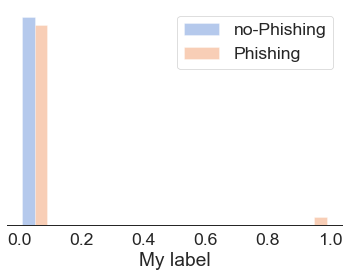

In [7]:
sns.set_context("paper", font_scale=2)
sns.set_style("white")
plt.rc('text', usetex=False)
fig, ax = plt.subplots()
sns.despine(left=True)

data1 = data.loc[data['Class']==0, 'IpAddress'].to_numpy()
data2 = data.loc[data['Class']==1, 'IpAddress'].to_numpy()

B = ['no-Phishing','Phishing']

ax.hist([data1, data2], histtype='bar', align='mid', density=True, label=B, alpha=0.4)

ax.set_xlabel('My label')
ax.get_yaxis().set_visible(False)
ax.legend()
plt.show()


### As seen above, only phishing websites have IP address in their URL. Let's plot all the features and divide them to classes.

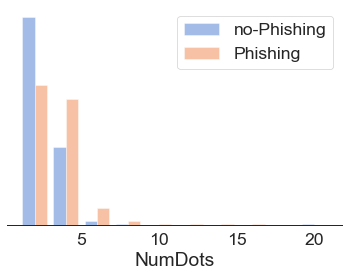

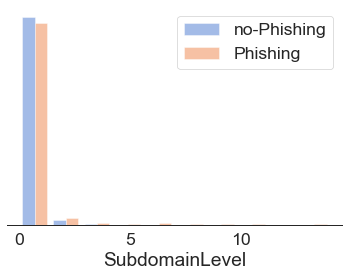

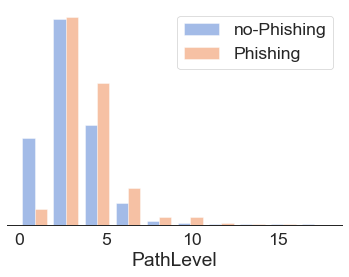

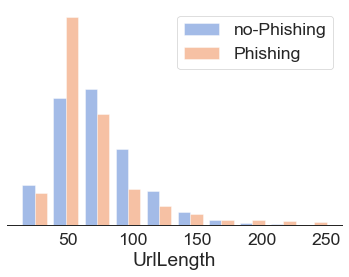

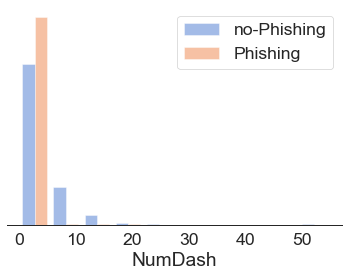

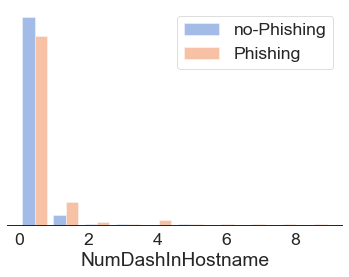

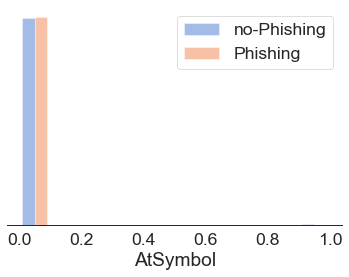

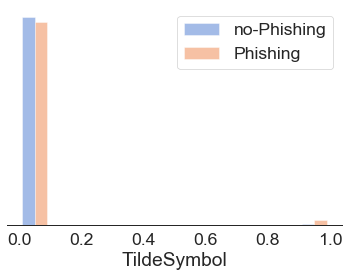

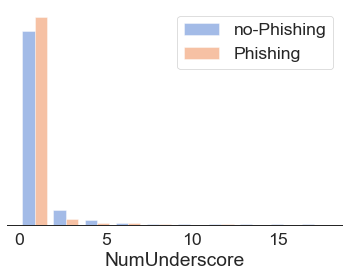

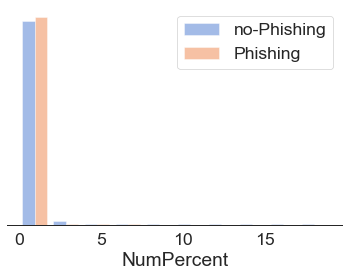

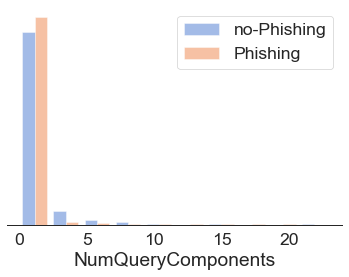

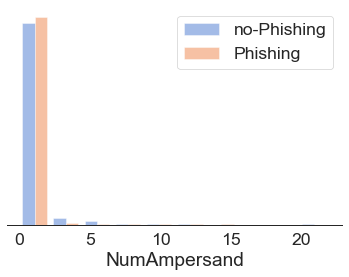

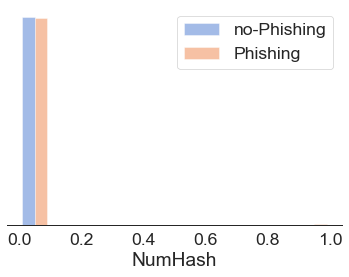

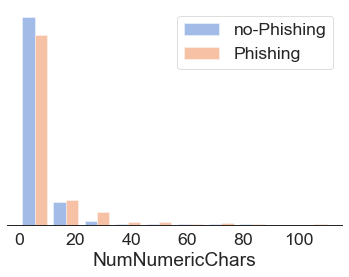

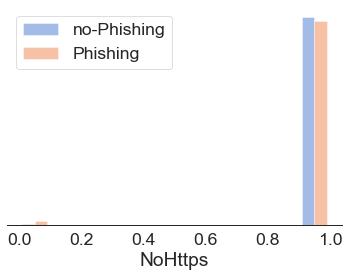

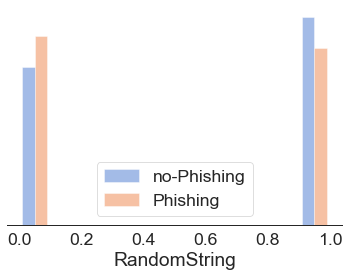

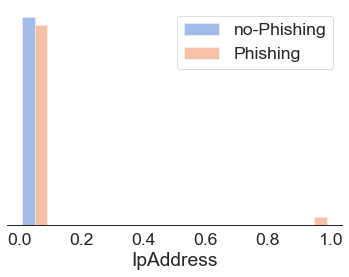

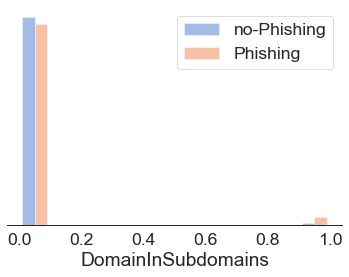

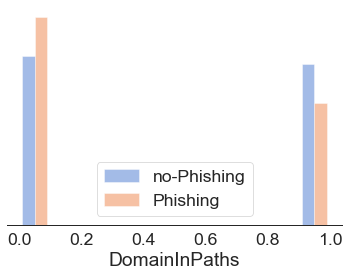

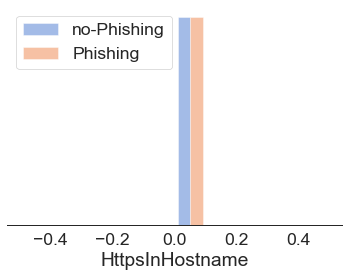

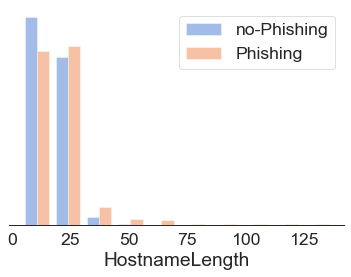

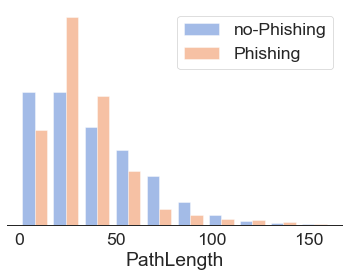

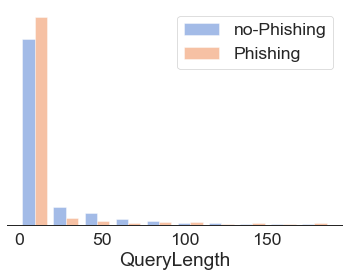

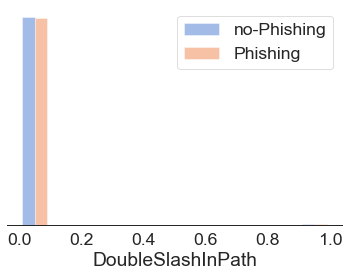

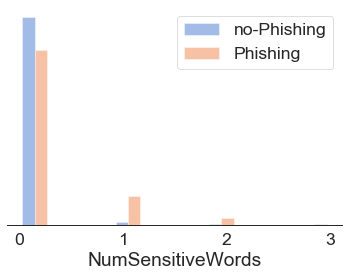

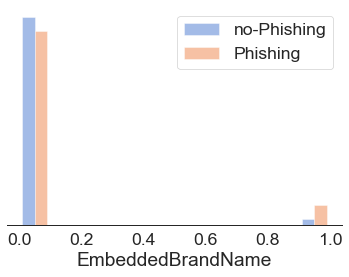

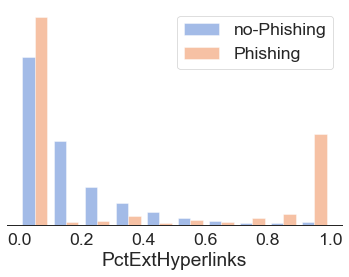

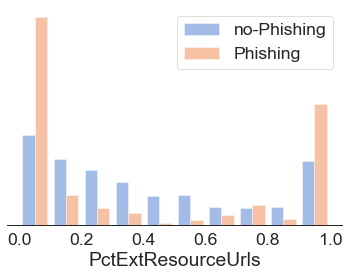

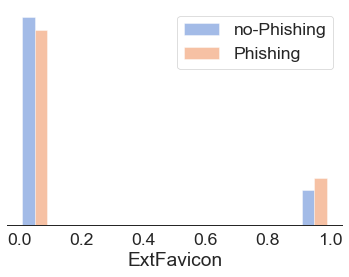

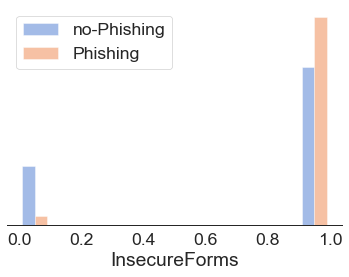

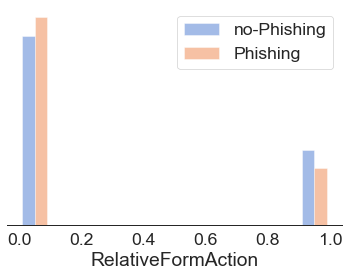

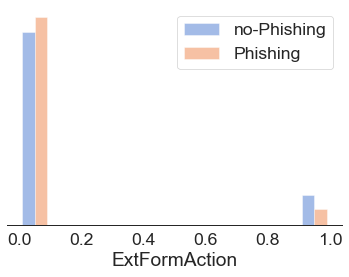

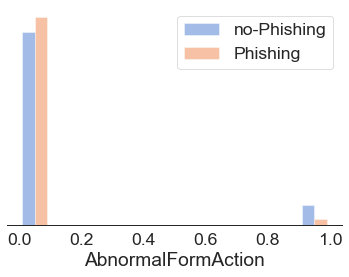

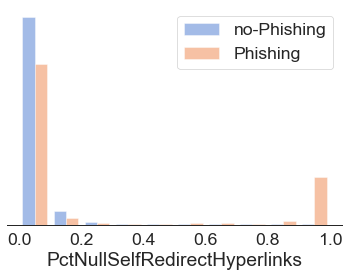

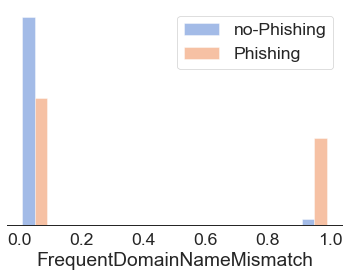

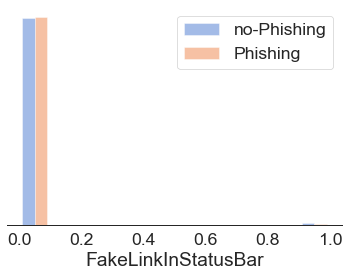

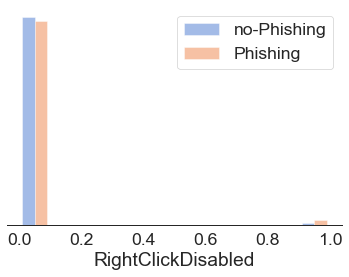

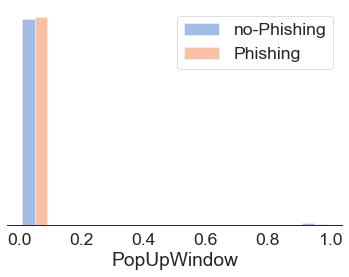

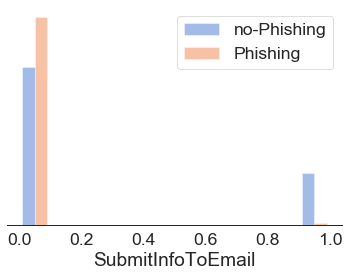

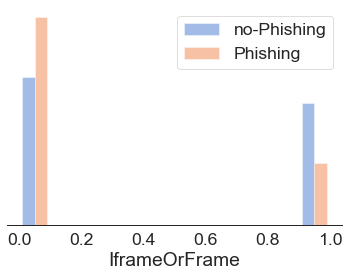

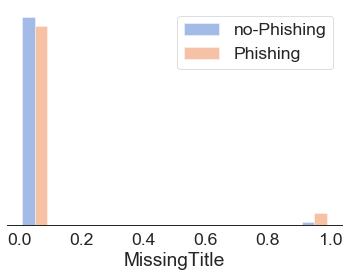

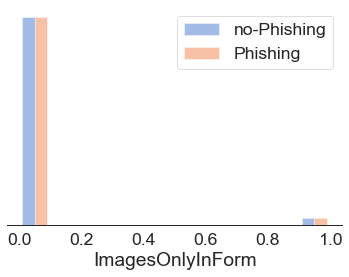

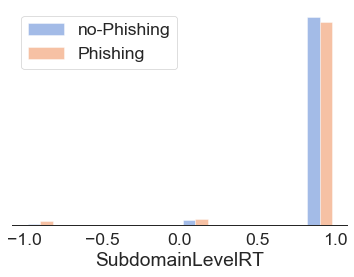

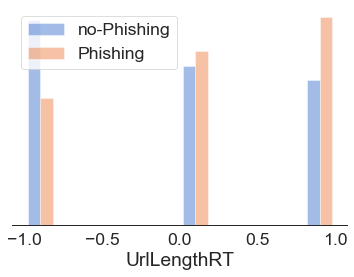

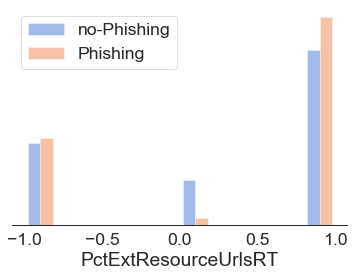

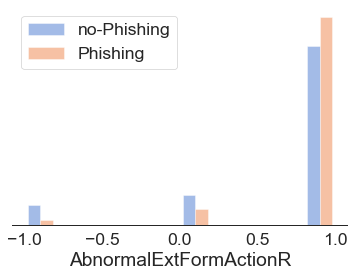

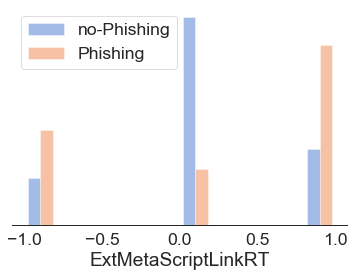

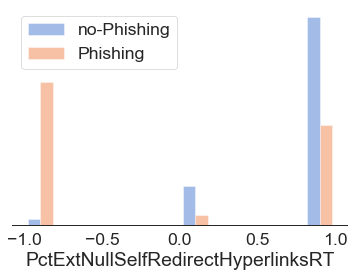

In [286]:
sns.set_context("paper", font_scale=2)
sns.set_style("white")


B = ['no-Phishing','Phishing']

for column in data.columns[:-1]:
    fig, ax = plt.subplots()
    sns.despine(left=True)

    data1 = data.loc[data['Class']==0, column].to_numpy()
    data2 = data.loc[data['Class']==1, column].to_numpy()
    ax.hist([data1, data2], histtype='bar', align='mid', density=True, label=B, alpha=0.5)
    ax.set_xlabel(column)
    ax.get_yaxis().set_visible(False)
    ax.legend()
    plt.show()

### From the histograms above, we can see that several features, such as 'AtSymbol', will hvae no added value in our algorithms since this data source doesn't contain any websites with @ symbol. Let's remove those features using a simple variance threshold method

In [8]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit(data)
data_std_th = data[data.columns[sel.get_support(indices=True)]]
print(data_std_th.shape)
print('Number of feaured removed = {}'.format(data.shape[1] - data_std_th.shape[1]))

print('\nSelected Data Features - ')
print(data.columns[:-1])

data_std_th.head(5)

(10000, 25)
Number of feaured removed = 24

Selected Data Features - 
Index(['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
       'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
       'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
       'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname',
       'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath',
       'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks',
       'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActio

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,...,QueryLength,RelativeFormAction,FrequentDomainNameMismatch,IframeOrFrame,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,Class
0,3.0,1.0,5.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,1.0,1
1,3.0,1.0,3.0,144.0,0.0,0.0,2.0,0.0,2.0,1.0,...,103.0,0.0,0.0,0.0,-1.0,1.0,1.0,1.0,1.0,1
2,3.0,1.0,2.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,1
3,3.0,1.0,6.0,79.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-1.0,1.0,1.0,1.0,-1.0,1
4,3.0,0.0,4.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,-1.0,0.0,-1.0,-1.0,1


# Models comparison - without feature selection

Split the data into features and labels.

In [9]:
features = list(data.columns.values)[:-1]
label = 'Class'

X = data[features].values
y = data[label].values

An helper function for computing the accuracy and for ploting the ROC curves.

This function runs the given classifier, checks it accuracy using K-fold cross validation and paints the resulted ROC curve.
The function also print out the model accuracy.

The idea was taken from - https://scikit-learn.org/0.18/auto_examples/model_selection/plot_roc_crossval.html

In [10]:
# Params - i.   Classifier - the algorithm to use, should support the methods: fit, predict_proba, score.
#          ii.  ax - a plt figure to paint the ROC curve on.
#          iii. title - added title to the figure.
# Returns -
# A list of scores, the size of n_splits - score for each round.
def run_cross_validation_roc(X_, y_, classifier, ax, title='',n_splits=10):
    
    cv = StratifiedKFold(n_splits=n_splits)

    scores = []
    aucs = []
    tprs = []
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    for (train, test) in cv.split(X_, y_):
        probs = classifier.fit(X_[train], y_[train]).predict_proba(X_[test])
        # Calculate ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_[test], probs[:, 1])
        interp_tpr = scipy.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(interp_tpr)
        # Calculate score
        scores.append(classifier.score(X_[test], y_[test])) 
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Luck')
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2)
    
    fig_title = 'ROC curve - {0} ({1})'.format(title, classifier.__class__.__name__)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=fig_title)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
    
    print(title + ' ' + classifier.__class__.__name__ + " - Accuracy: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))

    ax.legend(loc="lower right")
    ln = ax.plot()
    return scores
            
    

Check Logistic Regression LogisticRegression - Accuracy: 0.94 (+/- 0.03)


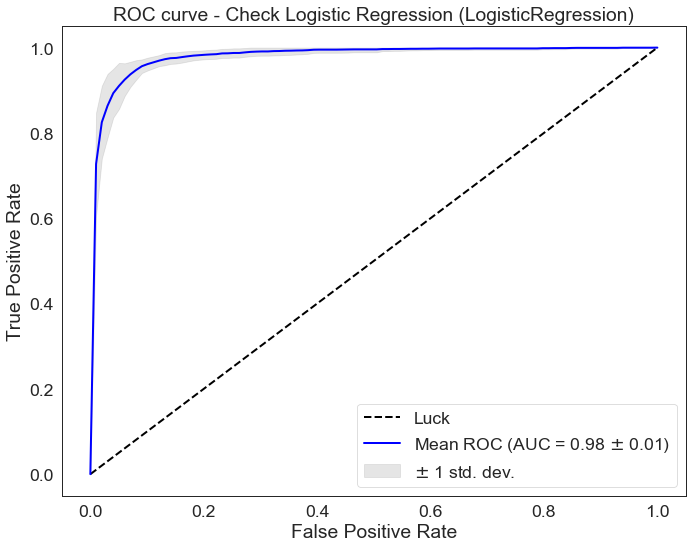

In [11]:
# Example use - 
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(10,8))

logistic_model = LogisticRegression(fit_intercept=True, solver='lbfgs', max_iter=10000)

score = run_cross_validation_roc(X, y, classifier=logistic_model, ax=ax, title='Check Logistic Regression')

plt.tight_layout()
plt.show()

### Model comparison - run all the models and print thier accuracy and plot the ROC curves

**Prepare the models -**

In [12]:
# Prepare the models - 
logistic_model = LogisticRegression(fit_intercept=True, solver='lbfgs', max_iter=10000)
tree_model = DecisionTreeClassifier(criterion='entropy',random_state=0)
knn_model = KNeighborsClassifier(n_neighbors=5, metric='hamming')
svm_model_rbf = SVC(kernel="rbf", random_state=0, gamma='auto', probability=True)
svm_model_linear = SVC(kernel="linear", random_state=0, gamma='auto', probability=True)
nb_model = GaussianNB()

# Add the title to each model - 
models = [
    {'model': logistic_model, 'title': 'Logistic Regression'},
    {'model': tree_model, 'title': 'Decision Tree'},
    {'model': knn_model, 'title': 'KNN'},
    {'model': svm_model_rbf, 'title': 'SVM RBF'},
    {'model': svm_model_linear, 'title': 'SVM Linear'},
    {'model': nb_model, 'title': 'Naive Bayes'},
]

**Plot the models' ROC cureves -** 

Logistic Regression LogisticRegression - Accuracy: 0.94 (+/- 0.03)
Decision Tree DecisionTreeClassifier - Accuracy: 0.96 (+/- 0.02)
KNN KNeighborsClassifier - Accuracy: 0.92 (+/- 0.06)
SVM RBF SVC - Accuracy: 0.88 (+/- 0.05)
SVM Linear SVC - Accuracy: 0.94 (+/- 0.03)
Naive Bayes GaussianNB - Accuracy: 0.84 (+/- 0.06)


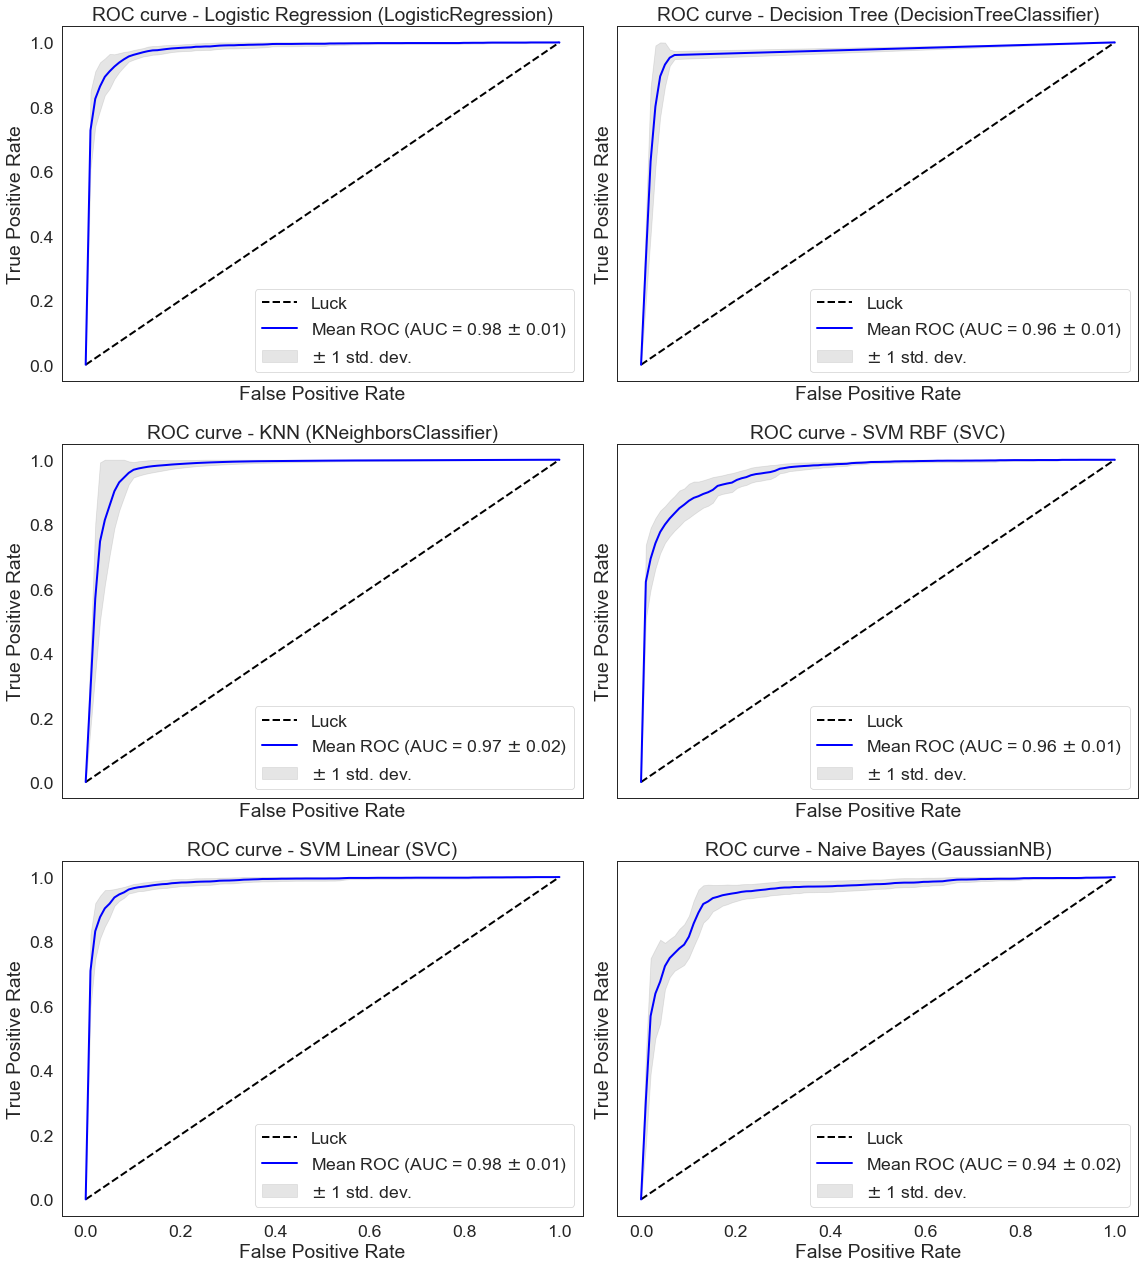

In [13]:
# Prepare the figure.
fig, ax_array = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(20,18))
scores = {}

# Run the models, plot the ROC and save the scores.
for i, ax in enumerate(ax_array.flat, start=0):
    model_scores = run_cross_validation_roc(X, y, classifier=models[i]['model'], ax=ax, title=models[i]['title'])
    scores[models[i]['title']] = model_scores
    
plt.tight_layout()
fig.subplots_adjust(right=0.8)
plt.show()

**Plot the models' scores as a boxplot for easy comparison-**

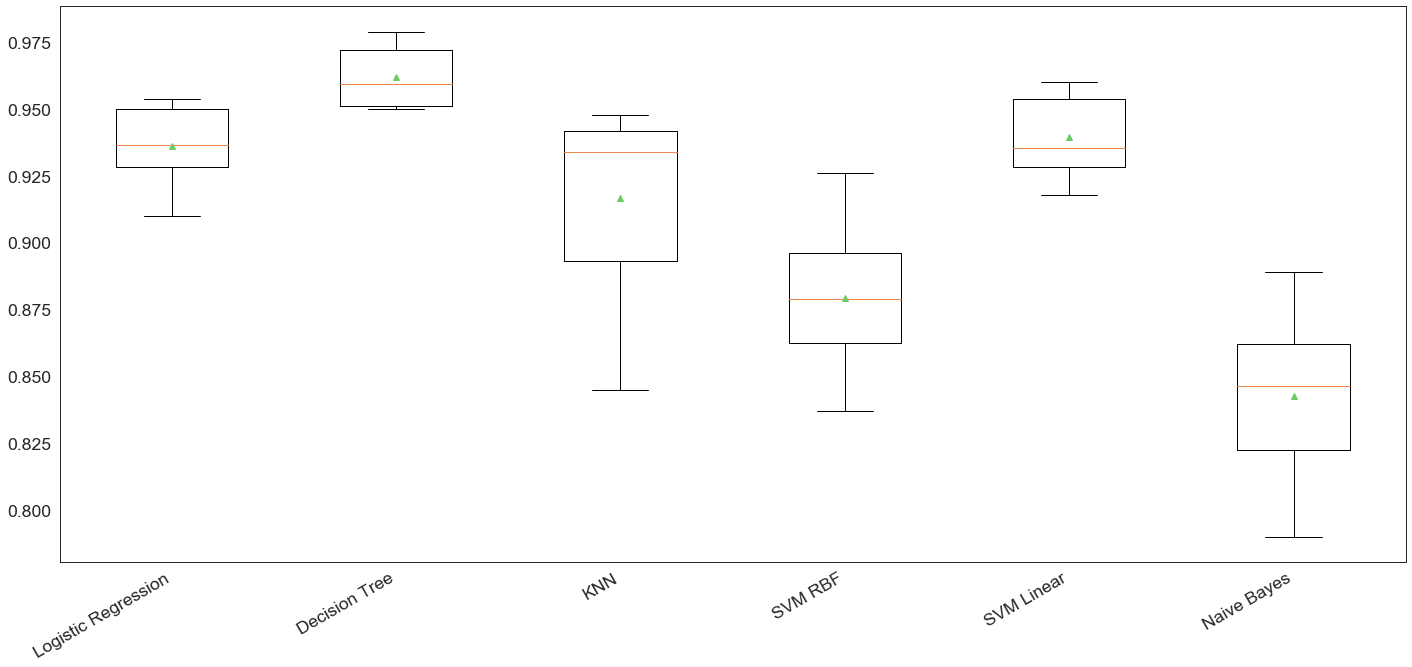

In [14]:
vals = []
labels = []
for s in scores:
    vals.append(scores[s])
    labels.append(s)

plt.figure(figsize=(20,10))
plt.boxplot(vals, labels=labels, showmeans=True)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# Models comparison - with naive feature selection

In [15]:
features_std = list(data_std_th.columns.values)[:-1]
label = 'Class'

X_std = data_std_th[features_std].values
y_std = data_std_th[label].values


# Prepare the models - 
logistic_model = LogisticRegression(fit_intercept=True, solver='lbfgs', max_iter=10000)
tree_model = DecisionTreeClassifier(criterion='entropy',random_state=0)
knn_model = KNeighborsClassifier(n_neighbors=5, metric='hamming')
svm_model_rbf = SVC(kernel="rbf", random_state=0, gamma='auto', probability=True)
svm_model_linear = SVC(kernel="linear", random_state=0, gamma='auto', probability=True)
nb_model = GaussianNB()

# Add the title to each model - 
models = [
    {'model': logistic_model, 'title': 'Logistic Regression'},
    {'model': tree_model, 'title': 'Decision Tree'},
    {'model': knn_model, 'title': 'KNN'},
    {'model': svm_model_rbf, 'title': 'SVM RBF'},
    {'model': svm_model_linear, 'title': 'SVM Linear'},
    {'model': nb_model, 'title': 'Naive Bayes'},
]


Logistic Regression LogisticRegression - Accuracy: 0.89 (+/- 0.06)
Decision Tree DecisionTreeClassifier - Accuracy: 0.90 (+/- 0.05)
KNN KNeighborsClassifier - Accuracy: 0.90 (+/- 0.07)
SVM RBF SVC - Accuracy: 0.85 (+/- 0.08)
SVM Linear SVC - Accuracy: 0.90 (+/- 0.05)
Naive Bayes GaussianNB - Accuracy: 0.84 (+/- 0.07)


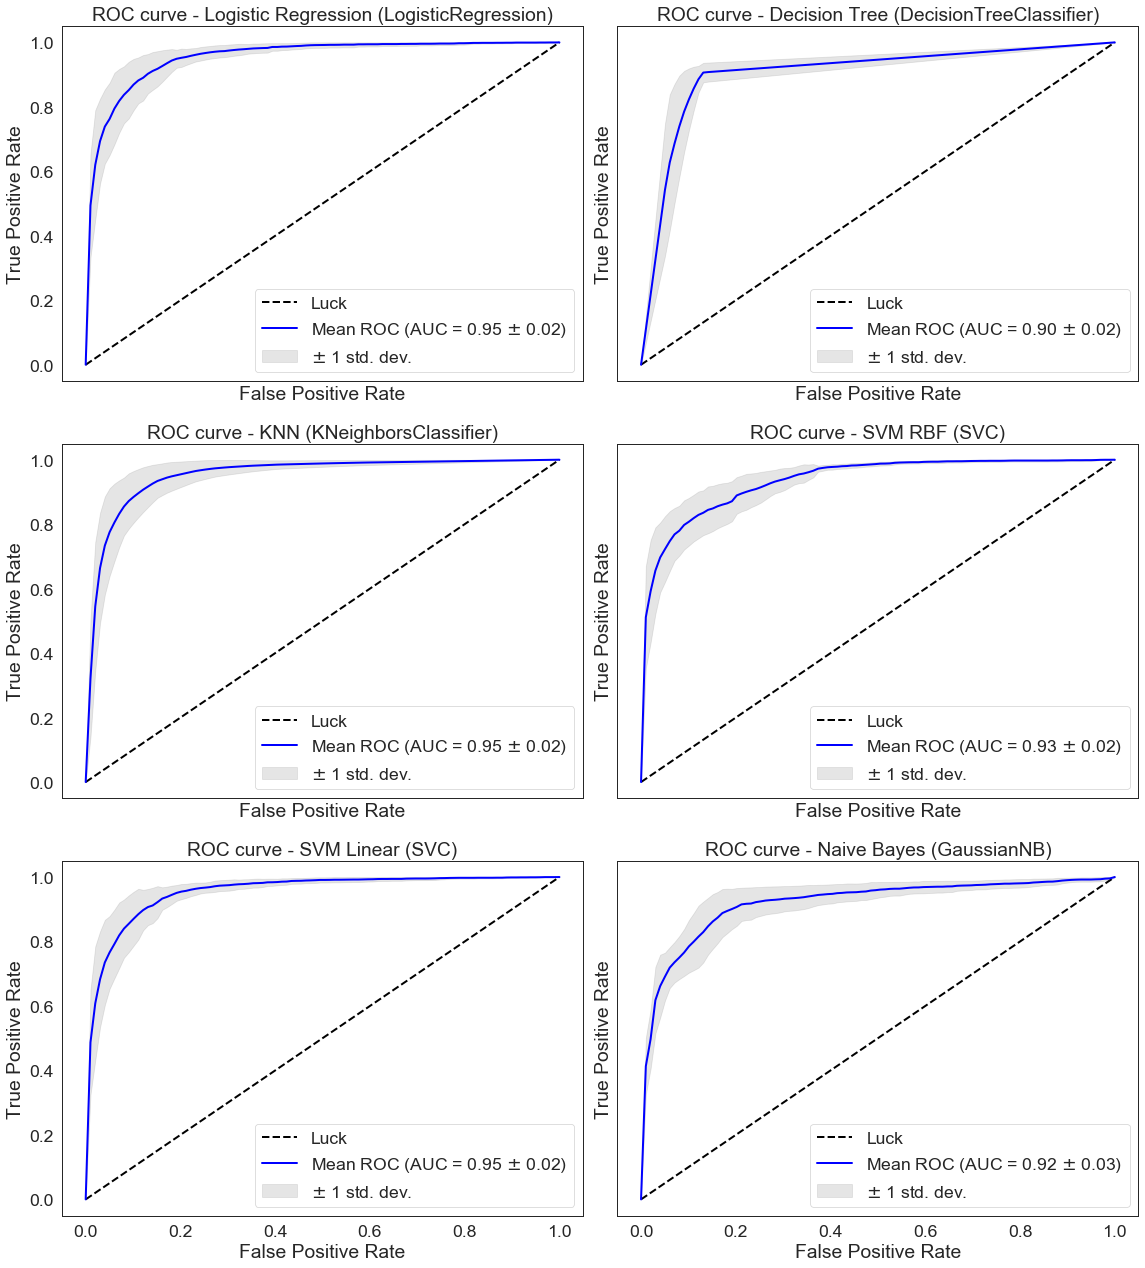

In [17]:
# Prepare the figure.
fig, ax_array = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(20,18))
std_scores = {}

for i, ax in enumerate(ax_array.flat, start=0):
    std_score = run_cross_validation_roc(X_std, y_std, classifier=models[i]['model'], ax=ax, title=models[i]['title'])
    std_scores[models[i]['title']] = std_score
    
plt.tight_layout()
fig.subplots_adjust(right=0.8)
plt.show()

**Plot the models' scores as a boxplot for easy comparison-**

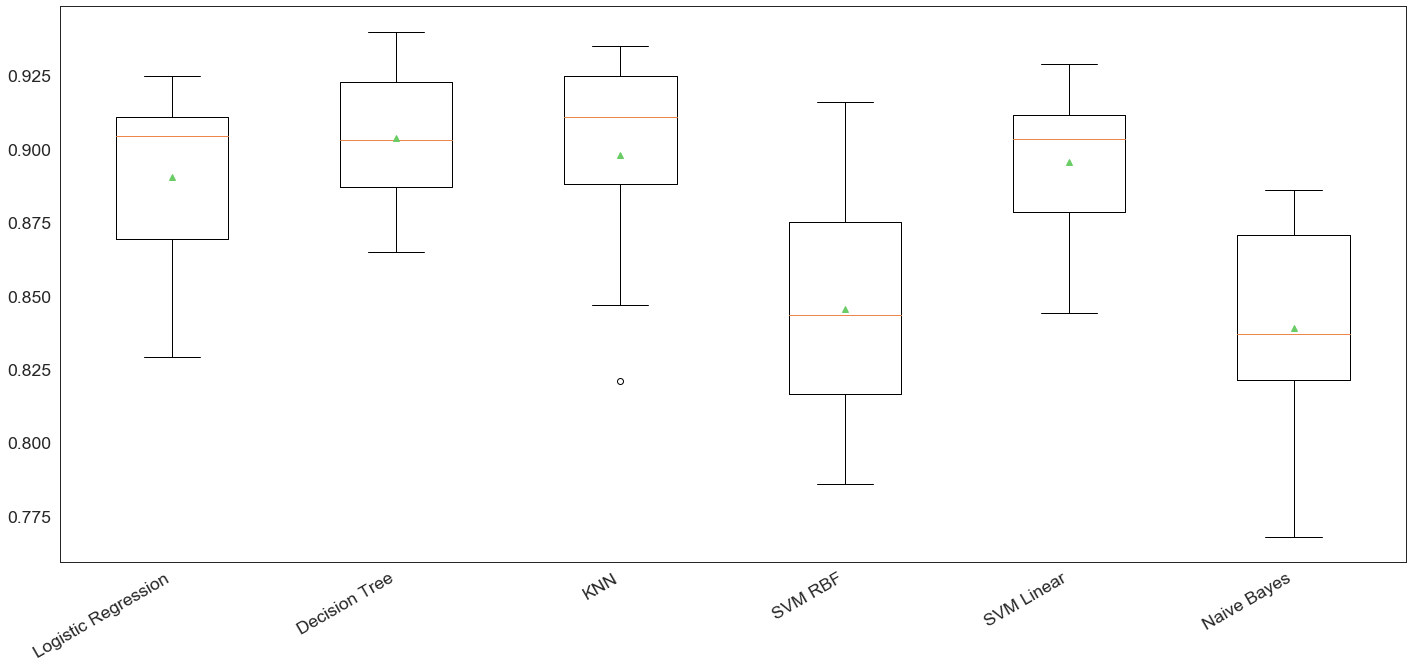

In [18]:
vals = []
labels = []
for s in std_scores:
    vals.append(std_scores[s])
    labels.append(s)

plt.figure(figsize=(20,10))
plt.boxplot(vals, labels=labels, showmeans=True)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# Optimize using neural network

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import *
from keras import callbacks
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Prepate test and train data for the network

In [20]:
features_std = list(data_std_th.columns.values)[:-1]
label = 'Class'

X_std = data_std_th[features_std].values
y_std = data_std_th[label].values

X_train, X_test, y_train, y_test = train_test_split(X_std, y_std, test_size=0.2, random_state=np.random.seed(7))

In [21]:
# Model building using the Sequential API
model = Sequential()

model.add(Dense(40, activation='relu',
          kernel_initializer='uniform',input_dim=X_std.shape[1]))
model.add(Dense(X_std.shape[1], activation='relu',
          kernel_initializer='uniform'))
model.add(Dense(1,  activation='sigmoid', 
          kernel_initializer='uniform'))

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                1000      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                984       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 2,009
Trainable params: 2,009
Non-trainable params: 0
_________________________________________________________________


### Train the network

In [22]:
es_cb = callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=5)

history = model.fit(X_train, y_train, validation_split=0.15, batch_size=10, epochs=128, verbose=1, callbacks=[es_cb])

scores = model.evaluate(X_test, y_test)

Train on 6800 samples, validate on 1200 samples
Epoch 1/128
6800/6800 [==============================] - 3s 401us/step - loss: 0.4018 - accuracy: 0.8115 - val_loss: 0.2813 - val_accuracy: 0.8883
Epoch 2/128
6800/6800 [==============================] - 2s 279us/step - loss: 0.2554 - accuracy: 0.9021 - val_loss: 0.2650 - val_accuracy: 0.8917
Epoch 3/128
6800/6800 [==============================] - 2s 286us/step - loss: 0.2386 - accuracy: 0.9066 - val_loss: 0.2808 - val_accuracy: 0.8758
Epoch 4/128
6800/6800 [==============================] - 2s 281us/step - loss: 0.2264 - accuracy: 0.9113 - val_loss: 0.2406 - val_accuracy: 0.9008
Epoch 5/128
6800/6800 [==============================] - 2s 275us/step - loss: 0.2213 - accuracy: 0.9157 - val_loss: 0.2513 - val_accuracy: 0.9075
Epoch 6/128
6800/6800 [==============================] - 2s 283us/step - loss: 0.2169 - accuracy: 0.9128 - val_loss: 0.2340 - val_accuracy: 0.9108
Epoch 7/128
6800/6800 [==============================] - 2s 280us/step

In [23]:
print('\nAccuracy score of the Neural Network {0:.2f}%'.format(scores[1]*100))


Accuracy score of the Neural Network 94.30%


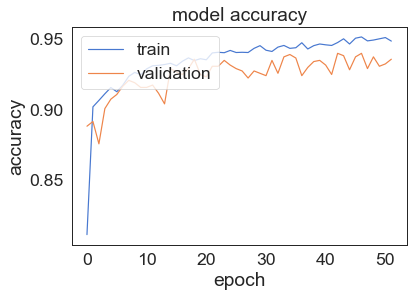

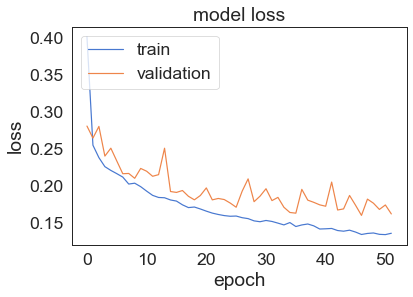

In [25]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**End of project**